In [193]:
from openclean.data.load import dataset
from openclean.pipeline import stream
import pandas as pd

pd.set_option('display.max_rows', None)

data_dir = '../project_data/'

data_list = [
    'data-cityofnewyork-us.8eq5-dtjb.csv', 
    'data-cityofnewyork-us.emuv-tx7t.csv', 
    'data-cityofnewyork-us.gt6r-wh7c.csv', 
    'data-cityofnewyork-us.un8d-rbed.csv', 
    'data-cityofnewyork-us.m6ad-jy3s.csv', 
    'data-cityofnewyork-us.wye7-nyek.csv', 
    'data-cityofnewyork-us.bty7-2jhb.csv', 
    'data-cityofnewyork-us.xrwg-eczf.csv', 
    'data-cityofnewyork-us.3rfa-3xsf.csv', 
    'data-cityofnewyork-us.aiww-p3af.csv', 
    'data-cityofnewyork-us.cwy2-px8b.csv', 
    'data-cityofnewyork-us.hy4q-igkk.csv'
]


# Park Borough also included in igkk & p3af

data_column = [
    'Borough', 
    'Borough', 
    'Borough', 
    'Borough', 
    'Borough', 
    'Borough', 
    'BOROUGH', 
    'Borough', 
    'Borough', 
    'Borough', 
    'Borough', 
    'Borough'
]

In [194]:
# our original strategy:
# 1. padding missing value with value 'UNKNOWN'
# 2. using uppercase for columns which could be used as reference data, such as BOROUGH
# 3. using knn cluster to check the spelling error
from openclean.cluster.knn import knn_clusters, knn_collision_clusters
from openclean.function.similarity.base import SimilarityConstraint
from openclean.function.similarity.text import LevenshteinDistance
from openclean.function.value.threshold import GreaterThan

from openclean.function.value.null import is_empty
from openclean.operator.transform.update import update


def calc_effectiveness(problem_rows, cleaned_rows):
    precision = intersected_num / cleaned_rows * 1.0 if cleaned_rows != 0 else 0.0
    recall = intersected_num / problem_rows * 1.0 if problem_rows != 0 else 0.0
    print(f"Data cleaned with precision {precision} and recall {recall} in {intersected_num} cleaning rows")
    return precision, recall

def print_cluster(cnumber, cluster):
    print('Cluster {} (of size {})\n'.format(cnumber, len(cluster)))
    for val, count in cluster.items():
        print('{} ({})'.format(val, count))
    print('\nSuggested value: {}\n\n'.format(cluster.suggestion()))

def perform_knn_cluster(ds_full, column, using_collision=True, minsize=2, t=0.6):
    values = ds_full.select(column).distinct()
    clusters = knn_clusters(values=values, sim=SimilarityConstraint(func=LevenshteinDistance(), pred=GreaterThan(t)), minsize=minsize) \
        if using_collision else knn_collision_clusters(values=values, sim=SimilarityConstraint(func=LevenshteinDistance(), pred=GreaterThan(t)), minsize=minsize)
    print('{} clusters of size {} or greater'.format(len(clusters), minsize))
    clusters.sort(key=lambda c: len(c), reverse=True)
    for i, cluster in enumerate(clusters):
        print_cluster(i + 1, cluster)

def profiling_data(datafile, column):
    ds_full = stream(datafile, encoding='utf-8')
    df = ds_full.to_df()
    borough = df[column].value_counts()
    print(borough)
    print("Total locations: ", len(borough))
    perform_knn_cluster(ds_full, column, using_collision=True)
    return df
    
def cleaning_data_original(df, column):
    rows_affected_upper = df[df[column] != df[column].str.upper()].index
    df = update(df, columns=column, func=str.upper)
    rows_affected_empty = df.isnull().index
    df = update(df, columns=column, func=lambda x: 'OTHER' if is_empty(x) else x)
    cleaned_rows = rows_affected_upper.union(rows_affected_empty)
    return df, cleaned_rows
    
def save_cleaned_data(df, output='result.csv'):
    df.to_csv('output')

In [195]:
# Since our aim was only to clean the columns which were overlap with the starting data set 
# hence we load all the dataset at once then performing data cleaning to create reference data

borough_df = pd.DataFrame(columns=['Borough'])

for i in range(len(data_list)):
    datafile = data_dir + data_list[i]
    print("Load data: ", datafile)
    ds = dataset(datafile, encoding='utf-8')
    ds.rename(columns={'BOROUGH': 'Borough'}, inplace=True)
    borough = ds[['Borough']]
    borough_df = borough_df.append(borough)
    
print(borough_df.value_counts())

Load data:  ../project_data/data-cityofnewyork-us.8eq5-dtjb.csv
Load data:  ../project_data/data-cityofnewyork-us.emuv-tx7t.csv
Load data:  ../project_data/data-cityofnewyork-us.gt6r-wh7c.csv
Load data:  ../project_data/data-cityofnewyork-us.un8d-rbed.csv
Load data:  ../project_data/data-cityofnewyork-us.m6ad-jy3s.csv
Load data:  ../project_data/data-cityofnewyork-us.wye7-nyek.csv
Load data:  ../project_data/data-cityofnewyork-us.bty7-2jhb.csv
Load data:  ../project_data/data-cityofnewyork-us.xrwg-eczf.csv
Load data:  ../project_data/data-cityofnewyork-us.3rfa-3xsf.csv
Load data:  ../project_data/data-cityofnewyork-us.aiww-p3af.csv
Load data:  ../project_data/data-cityofnewyork-us.cwy2-px8b.csv
Load data:  ../project_data/data-cityofnewyork-us.hy4q-igkk.csv
Borough                                          
Unspecified                                          2065646
MANHATTAN                                            1744766
QUEENS                                               1521834

In [196]:
# Next we cleaned the overall column 'Borough' and generate our reference data
# First we extracted only the column 'Borough'
borough_df.to_csv('../reference_data/borough_rows_all.csv', index=None)

In [197]:
# Load the intermediate dataset as stream format
ds_full = stream('../reference_data/borough_rows_all.csv', encoding='utf-8')

In [198]:
# And perform knn cluster
perform_knn_cluster(ds_full, 'Borough')

34 clusters of size 2 or greater
Cluster 1 (of size 7)

Bronx;#Brooklyn;#Manhattan;#Queens;#Staten Island (14)
Brooklyn;#Staten Island (3)
Bronx;#Brooklyn;#Queens;#Staten Island;#Manhattan (1)
Manhattan;#Brooklyn;#Bronx;#Queens;#Staten Island (1)
Queens;#Brooklyn;#Staten Island (1)
Bronx;#Queens;#Staten Island (1)
Bronx;#Brooklyn;#Queens;#Staten Island (1)

Suggested value: Bronx;#Brooklyn;#Manhattan;#Queens;#Staten Island


Cluster 2 (of size 6)

Brooklyn;#Manhattan (3)
Brooklyn;#Manhattan;#Staten Island (1)
Queens;#Brooklyn;#Staten Island (1)
Bronx;#Brooklyn;#Queens;#Staten Island (1)
Bronx;#Queens;#Staten Island (1)
Brooklyn;#Staten Island (3)

Suggested value: Brooklyn;#Manhattan


Cluster 3 (of size 5)

Brooklyn;#Manhattan;#Staten Island (1)
Bronx;#Brooklyn;#Manhattan;#Queens (3)
Manhattan;#Brooklyn;#Bronx;#Queens;#Staten Island (1)
Bronx;#Brooklyn;#Queens;#Staten Island (1)
Bronx;#Brooklyn;#Manhattan;#Queens;#Staten Island (14)

Suggested value: Bronx;#Brooklyn;#Manhattan;#Queens

In [199]:
# From cluster 29 we noticed there was a typo for 'Brooklyhn' ('Brooklyn'), transform the overall stream to DataFrame
df_overall = ds_full.to_df()

In [200]:
# Than we apply our original strategy to these datasets to get the effectiveness of the strategy

df_clean = update(df_overall, columns='Borough', func=str.upper)
df_clean = update(df_clean, columns='Borough', func=lambda x: 'BROOKLYN' if str(x) == 'BROOKLYHN' else x)
df_clean = update(df_clean, columns='Borough', func=lambda x: 'UNSPECIFIED' if is_empty(x) else x)
borough = df_clean['Borough'].value_counts()
print(borough)

UNSPECIFIED                                          2077635
MANHATTAN                                            1747047
QUEENS                                               1524036
BROOKLYN                                             1519321
BRONX                                                 654250
STATEN ISLAND                                         398418
LIC                                                      265
LONG ISLAND CITY                                         111
MN                                                       100
BK                                                        92
QN                                                        51
BX                                                        39
S.I.                                                      30
JACKSON HEIGHTS                                           24
FLUSHING                                                  20
SI                                                        15
BRONX;#BROOKLYN;#MANHATT

In [201]:
# Measure effectiveness of the borough column
# In this step, we would calculate the overall effectiveness of our original data clean strategy regarding borough
# From the data above, we inspected the problem of data set manually

# 1. In our original strategy, we fill the borough which was unknown to 'OTHER', while in this case some were marked as 'Unspecified', hence we use UNSPECIFIED instead of UIKNOWN
# 2. We converted the all the values to uppercase
# 3. We use cluster to check the spelling error

# From the saved intermediate data set, we found total number of problem rows from the total 12 data set with column borough: 2087274
# Next we cleaned the overall data set to check the effectiveness of our method:

# The overall rows changed by our strategy was: 2086772
# For some columns, we found our strategy could not clean the data into correct format, the number of row was: 679
# Hence we get our precision : 
precision = 1.0 * (2086772 - 679) / 2086772
recall = 1.0 * (2086772 - 679) / 2087274
print(f'Precision: {precision}, Recall: {recall}')

Precision: 0.9996746170640588, Recall: 0.9994341902404763


In [202]:
# We refined our strategy
# Since we found for some rows such as "BRONX;#QUEENS;#STATEN ISLAND", we changed this by only using the first borough
df_clean = update(df_clean, columns='Borough', func=lambda x: str(x).split(';')[0])
print(df_clean.value_counts())

Borough         
UNSPECIFIED         2077635
MANHATTAN           1747062
QUEENS              1524049
BROOKLYN            1519333
BRONX                654282
STATEN ISLAND        398427
LIC                     265
LONG ISLAND CITY        111
MN                      100
BK                       92
QN                       51
BX                       39
S.I.                     30
JACKSON HEIGHTS          24
FLUSHING                 20
SI                       15
JAMAICA                   9
BAYSIDE                   9
10014                     6
BROORLYN                  2
dtype: int64


In [249]:
# We also noticed that the knn cluster could not specify a typo 'BROORLYN'
# There were a digital item '10014', after we referred from the internet, we assdf_clean = update(df_clean, columns='Borough', func=lambda x: 'MANHATTAN' if str(x) == '10014' else x)
# We assume it was a zipcode located in Manhattan, hence we replace it with 'MANHATTAN'
# Hence we have a reference data to show all the NYC zip code and their borough
# Ref: https://github.com/erikgregorywebb/nyc-housing/blob/master/Data/nyc-zip-codes.csv
zip_code = dataset('../reference_data/nyc-zip-codes.csv')
zip_code = update(zip_code, columns='Borough', func=str.upper)
zip_map = dict(zip(zip_code['ZipCode'],zip_code['Borough']))

df_clean = update(df_clean, columns='Borough', func=lambda x: 'BROOKLYN' if str(x) == 'BROORLYN' else x)
df_clean = update(df_clean, columns='Borough', func=lambda x: zip_map[str(x)] if str(x) in zip_map else x)

print(df_clean.value_counts())

Borough         
UNSPECIFIED         2077635
MANHATTAN           1747168
QUEENS              1524100
BROOKLYN            1519427
BRONX                654321
STATEN ISLAND        398472
LONG ISLAND CITY        376
JACKSON HEIGHTS          24
FLUSHING                 20
BAYSIDE                   9
JAMAICA                   9
dtype: int64


In [250]:
# Now we noticed that there were also some abbreviation representation of the borough, for example, 'MN' for 'Manhattan', 'LIC' for 'Long ISLAND CITY'
# We fixed them using their full names
# We also generated a reference data from the abbreviation we encountered
# Our new strategy was mapping unformatted value from formatted reference data generated from starting dataset

abb_map = {'MN': 'MANHATTAN', 
           'BK': 'BROOKLYN', 
           'QN': 'QUEENS', 
           'BX': 'BRONX', 
           'S.I.': 'STATEN ISLAND', 
           'LIC': 'LONG ISLAND CITY', 
           'SI': 'STATEN ISLAND'}

df_clean = update(df_clean, columns='Borough', func=lambda x: abb_map[str(x)] if str(x) in abb_map else x)
print(df_clean.value_counts())

Borough         
UNSPECIFIED         2077635
MANHATTAN           1747168
QUEENS              1524100
BROOKLYN            1519427
BRONX                654321
STATEN ISLAND        398472
LONG ISLAND CITY        376
JACKSON HEIGHTS          24
FLUSHING                 20
BAYSIDE                   9
JAMAICA                   9
dtype: int64


In [206]:
# Now we implement our new data clean strategy
from openclean.function.eval.base import Col

def improved_data_clean_borough(ds_full, column):
    abb_map = {'MN': 'MANHATTAN', 'BK': 'BROOKLYN', 'QN': 'QUEENS', 'BX': 'BRONX', 'S.I.': 'STATEN ISLAND', 'LIC': 'LONG ISLAND CITY', 'SI': 'STATEN ISLAND'}
    ds_full = update(ds_full, columns=column, func=str.upper)
    ds_full = update(ds_full, columns=column, func=lambda x: 'BROOKLYN' if str(x) == 'BROOKLYHN' else x)
    ds_full = update(ds_full, columns=column, func=lambda x: 'UNSPECIFIED' if is_empty(x) else x)
    ds_full = update(ds_full, columns=column, func=lambda x: str(x).split(';')[0])
    ds_full = update(ds_full, columns=column, func=lambda x: 'MANHATTAN' if str(x) == '10014' else x)
    ds_full = update(ds_full, columns=column, func=lambda x: 'BROOKLYN' if str(x) == 'BROORLYN' else x)
    ds_full = update(ds_full, columns=column, func=lambda x: abb_map[str(x)] if str(x) in abb_map else x)
    return ds_full

## Apply new strategy to the datasets

Since we measured our old strategy by precision and recall, next we generate our reference data with our new strategy file to file.

First we define the visualisation function, for borough column, we only use histogram and treemap, to scale the borough with difference value and show the value count in each borough

In [244]:
import matplotlib.pyplot as plt
import squarify
import math

def draw_tree_map(numbers, groups):
    df_treemap = pd.DataFrame({'borough_counts': [math.log(x) for x in numbers], 'borough': groups })
    squarify.plot(sizes=df_treemap['borough_counts'], label=df_treemap['borough'], alpha=.8)
    plt.axis('off')
    plt.show()
    
def draw_hist(numbers, groups):
    plt.barh(range(numbers.count()), [math.log(x) for x in numbers], height=0.7, color='steelblue', alpha=0.8)
    plt.xlabel('counts (log)')
    plt.ylabel('Borough')
    plt.yticks(range(groups.count()), groups)

In [245]:
res = df_clean.value_counts().reset_index()
res.columns = ['Borough', 'count']
print(res)

             Borough    count
0        UNSPECIFIED  2077635
1          MANHATTAN  1747162
2             QUEENS  1524100
3           BROOKLYN  1519427
4              BRONX   654321
5      STATEN ISLAND   398472
6   LONG ISLAND CITY      376
7    JACKSON HEIGHTS       24
8           FLUSHING       20
9            BAYSIDE        9
10           JAMAICA        9
11             10014        6


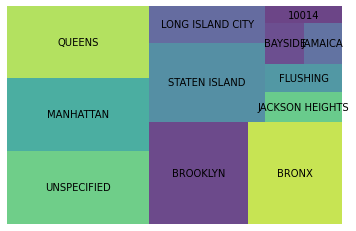

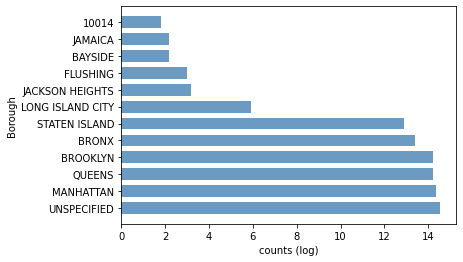

In [246]:
draw_tree_map(res['count'], res['Borough'])
draw_hist(res['count'], res['Borough'])

## dataset data-cityofnewyork-us.8eq5-dtjb.csv

In [ ]:
# Profile dataset
datafile = data_dir + data_list[0]
column = data_column[0]
df = profiling_data(datafile, column)
df, cleaned_rows = cleaning_data_original(df, column)
df

In [ ]:
# Get effectiveness
# Step 1: Get rows which should be cleaned
calc_effectiveness(0, len(cleaned_rows))

## data-cityofnewyork-us.emuv-tx7t.csv

In [ ]:
# Profile dataset
datafile = data_dir + data_list[1]
column = data_column[1]
profiling_data(datafile, column)

## data-cityofnewyork-us.gt6r-wh7c.csv

In [ ]:
# Profile dataset
datafile = data_dir + data_list[2]
column = data_column[2]
profiling_data(datafile, column)

## data-cityofnewyork-us.un8d-rbed.csv

In [ ]:
# Profile dataset
datafile = data_dir + data_list[3]
column = data_column[3]
profiling_data(datafile, column)

## dataset data-cityofnewyork-us.m6ad-jy3s.csv

In [ ]:
# Profile dataset
datafile = data_dir + data_list[4]
column = data_column[4]
profiling_data(datafile, column)

## dataset data-cityofnewyork-us.wye7-nyek.csv

In [ ]:
# Profile dataset
datafile = data_dir + data_list[5]
column = data_column[5]
profiling_data(datafile, column)

## dataset data-cityofnewyork-us.bty7-2jhb.csv

In [ ]:
# Profile dataset
datafile = data_dir + data_list[6]
column = data_column[6]
profiling_data(datafile, column)

## dataset data-cityofnewyork-us.xrwg-eczf.csv

In [ ]:
# Profile dataset
datafile = data_dir + data_list[7]
column = data_column[7]
profiling_data(datafile, column)

## dataset data-cityofnewyork-us.3rfa-3xsf.csv

In [ ]:
# Profile dataset
datafile = data_dir + data_list[8]
column = data_column[8]
profiling_data(datafile, column)

## dataset data-cityofnewyork-us.aiww-p3af.csv

In [ ]:
# Profile dataset
datafile = data_dir + data_list[9]
column = data_column[9]
profiling_data(datafile, column)

## dataset data-cityofnewyork-us.cwy2-px8b.csv

In [ ]:
# Profile dataset
datafile = data_dir + data_list[10]
column = data_column[10]
profiling_data(datafile, column)

## dataset data-cityofnewyork-us.hy4q-igkk.csv

In [ ]:
# Profile dataset
datafile = data_dir + data_list[11]
column = data_column[11]
profiling_data(datafile, column)

In [ ]:
# Next we perform our new cleaning strategy regarding rolumn 'Borough' to all the data sets

datafile = data_dir + data_list[5]
print(datafile)
ds_test = dataset(datafile, encoding='utf-8')
# column = data_column[5]
ds_test = improved_data_clean_borough(ds_test, column)
bor_test = ds_test['Borough']
print(bor_test.value_counts())